![](https://miro.medium.com/max/964/0*tVCene42rgUTNv9Q.png)

Paquete prophet de facebook.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

# Data
Los datos que vamos a utilizar son los datos de consumo energético horario de PJM. El consumo de energía tiene algunas características únicas. Será interesante ver cómo las capta prophet.

Se ha extraído el "PJM East" USA, que contiene datos de 2002 a 2018 de toda la región oriental.

In [3]:
pjme = pd.read_csv('data/PJME_hourly.csv',
                   index_col=[0], parse_dates=[0]) # Fijamos la columna índice y sabemos que tiene fechas

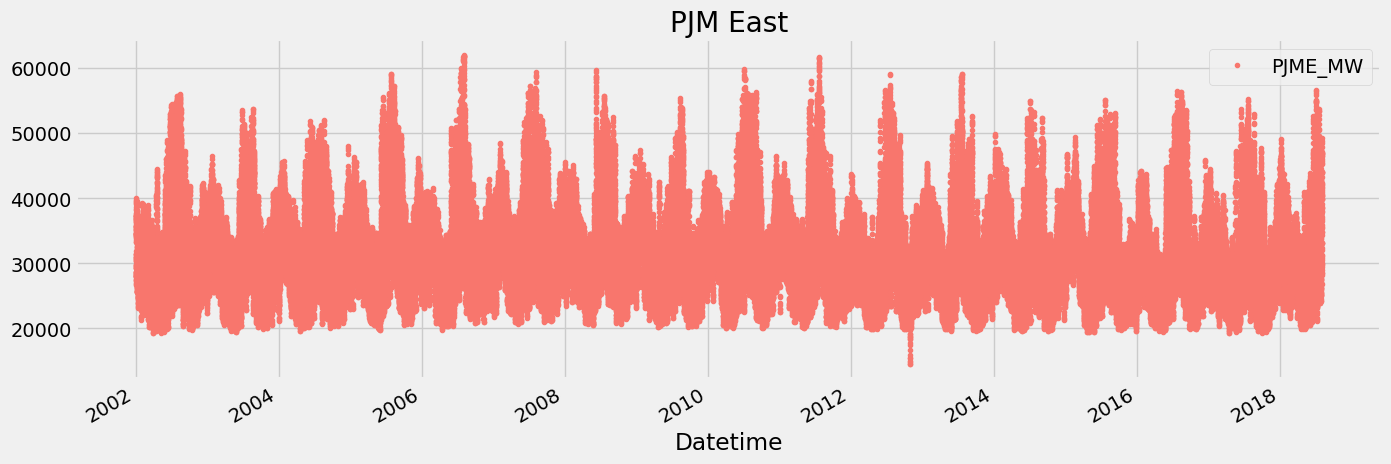

In [4]:
# Paleta de colores para el trazado
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
plt.show()

# EDA

Crearemos algunas series temporales para ver cómo influyen en las tendencias el día de la semana, la hora, la época del año, etc..

In [5]:
pjme

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
...,...
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0


In [6]:
def create_features(df, label=None):
    """
    Crea características de series temporales a partir de un índice datetime.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(pjme, label='PJME_MW')

features_and_target = pd.concat([X, y], axis=1)

In [7]:
# Ver las características y objetivos
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


## Trazar las características para ver las tendencias
- La demanda de electricidad presenta fuertes propiedades diarias y estacionales.
- El día de la semana también parece mostrar diferencias en los picos

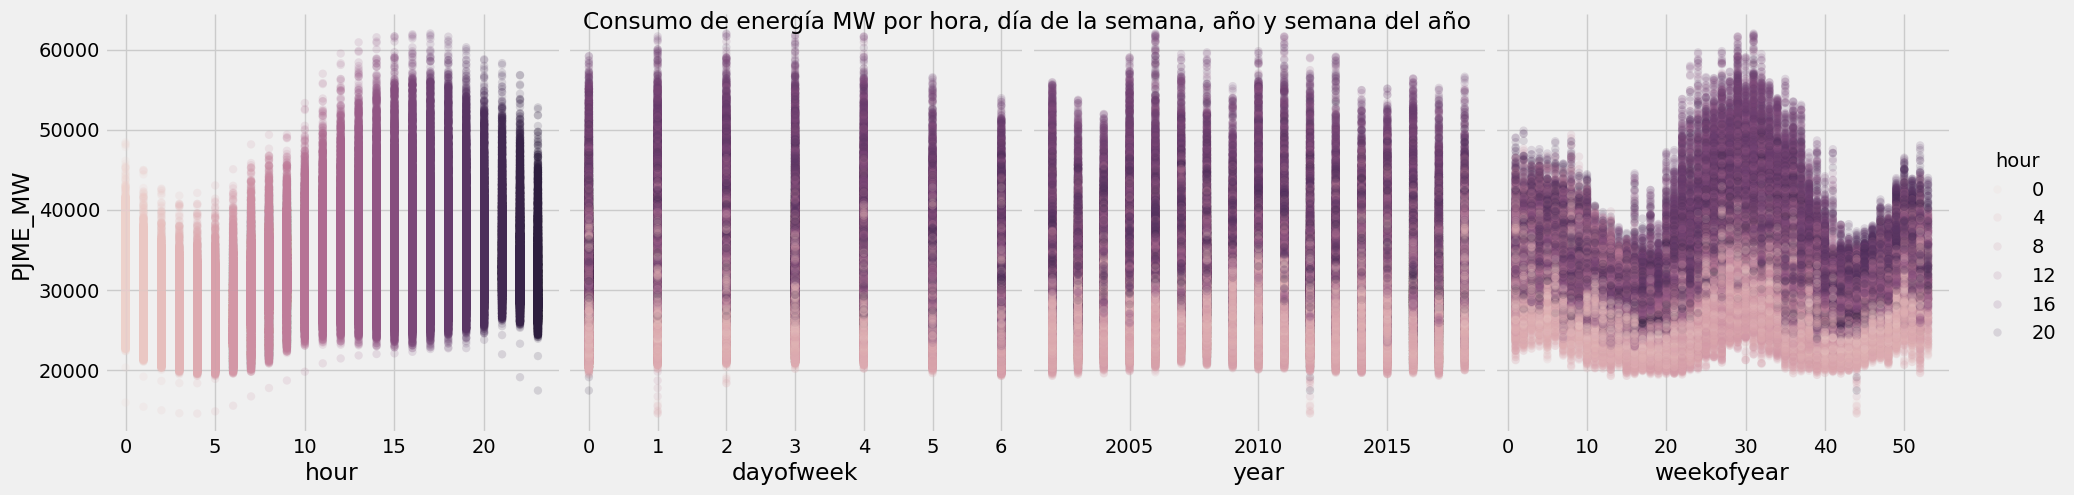

In [8]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='PJME_MW',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Consumo de energía MW por hora, día de la semana, año y semana del año')
plt.show()

# Train/Test Split
Corta los datos posteriores a 2015 para utilizarlos como conjunto de validación. Nos entrenaremos con datos anteriores.

In [9]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

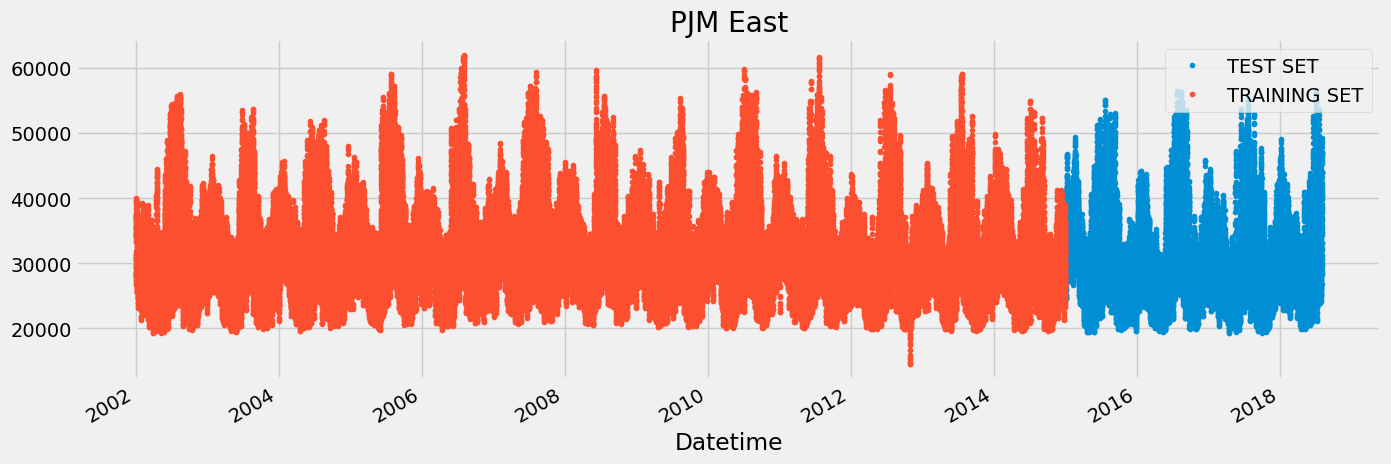

In [10]:
# Traza el tren y la prueba para que puedas ver dónde hemos dividido
pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

# Modelo Prophet simple
- El modelo Prophet espera que el conjunto de datos tenga un nombre específico. Cambiaremos el nombre de las columnas de nuestro marco de datos antes de introducirlo en el modelo.

In [11]:
# Formatear los datos para el modelo profeta utilizando ds e y
pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'}).head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [12]:
# Configuración y ajuste del modelo
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW':'y'}))

21:11:18 - cmdstanpy - INFO - Chain [1] start processing
21:12:40 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# Predecir sobre el conjunto de entrenamiento con el modelo
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [14]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31200.339206,23906.339751,32824.369078,31200.339206,31200.339206,-2842.562168,-2842.562168,-2842.562168,-4430.590454,...,1281.474328,1281.474328,1281.474328,306.553958,306.553958,306.553958,0.0,0.0,0.0,28357.777038
1,2015-01-01 02:00:00,31200.300721,22415.377400,31214.492279,31200.300721,31200.300721,-4347.079710,-4347.079710,-4347.079710,-5927.617356,...,1272.694228,1272.694228,1272.694228,307.843418,307.843418,307.843418,0.0,0.0,0.0,26853.221011
2,2015-01-01 03:00:00,31200.262235,21389.063557,30641.185984,31200.262235,31200.262235,-5218.803832,-5218.803832,-5218.803832,-6790.687108,...,1262.708907,1262.708907,1262.708907,309.174370,309.174370,309.174370,0.0,0.0,0.0,25981.458403
3,2015-01-01 04:00:00,31200.223749,21205.151625,30521.952256,31200.223749,31200.223749,-5360.281813,-5360.281813,-5360.281813,-6922.470785,...,1251.642133,1251.642133,1251.642133,310.546839,310.546839,310.546839,0.0,0.0,0.0,25839.941936
4,2015-01-01 05:00:00,31200.185263,22165.595657,31096.112603,31200.185263,31200.185263,-4685.843322,-4685.843322,-4685.843322,-6237.434051,...,1239.629878,1239.629878,1239.629878,311.960851,311.960851,311.960851,0.0,0.0,0.0,26514.341942


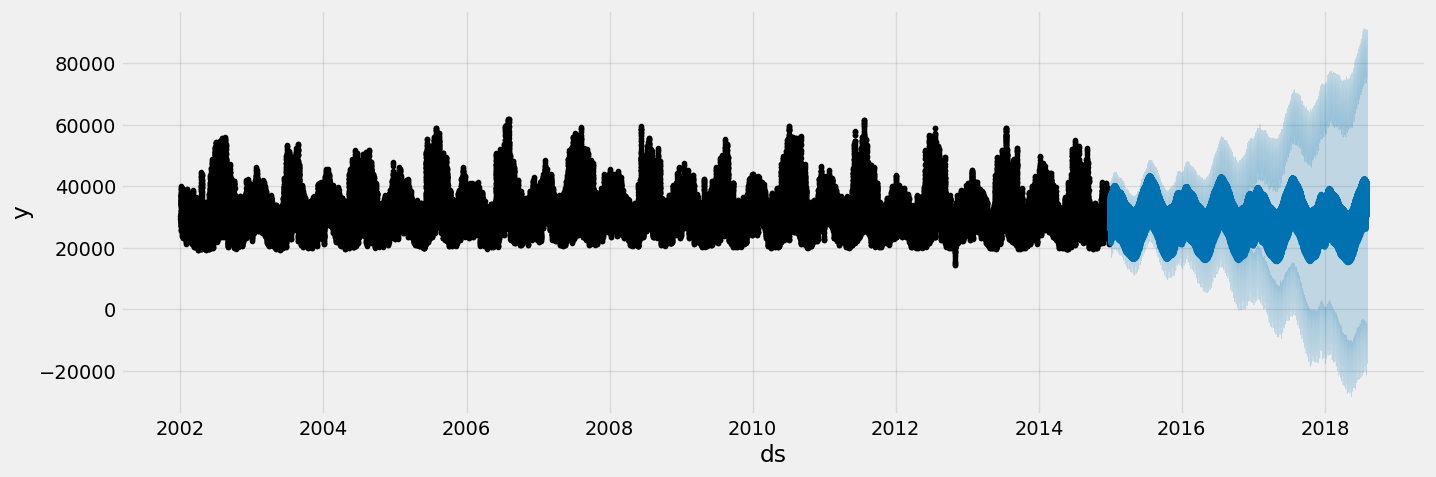

In [15]:
# Trazar la previsión
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

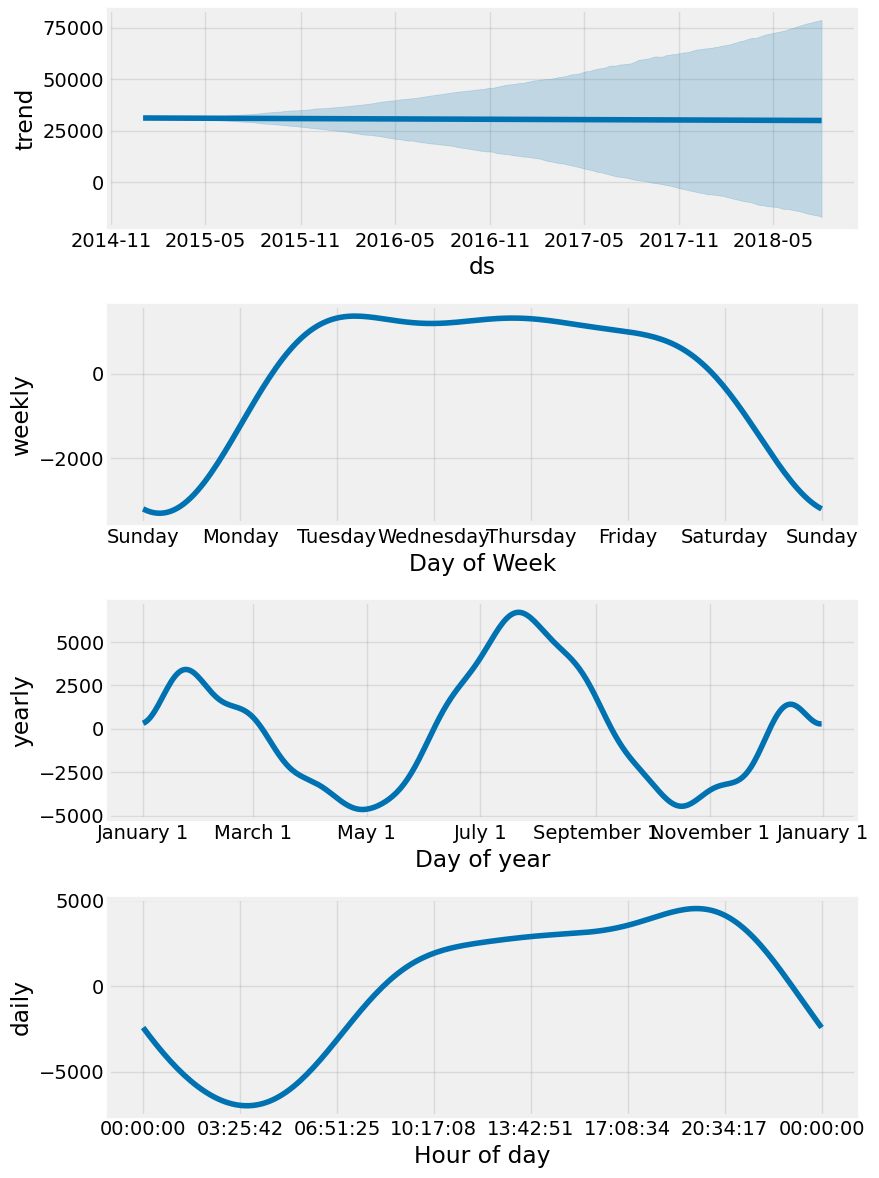

In [16]:
# Trazar los componentes del modelo
fig = model.plot_components(pjme_test_fcst)

# Comparar previsiones con datos reales

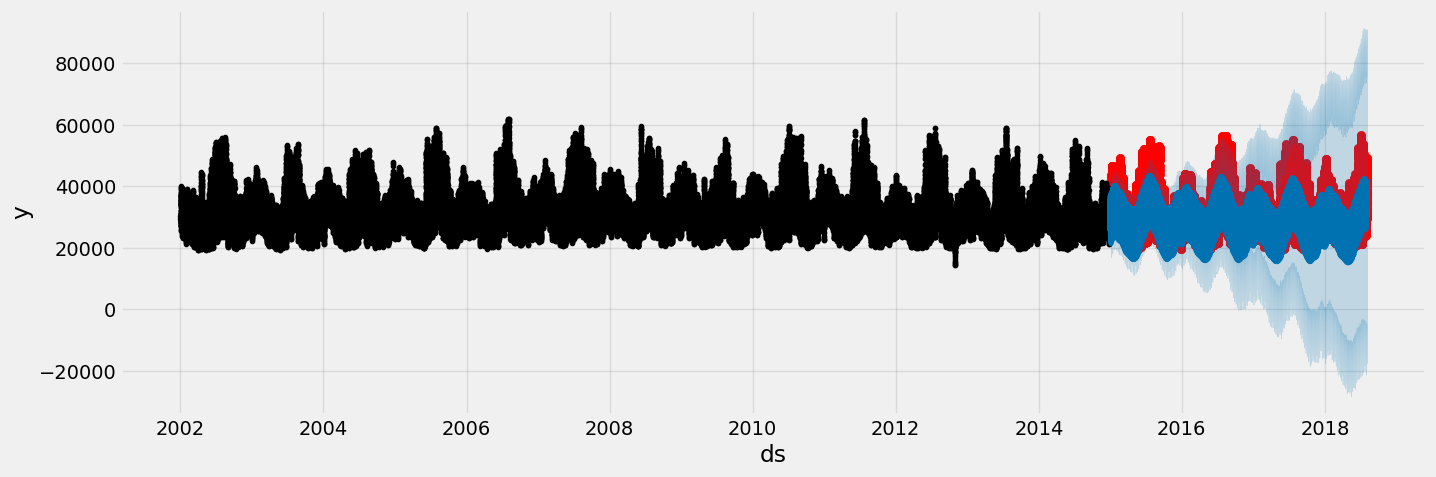

In [17]:
# Representar la previsión con los datos reales
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

# Mira el primer mes de predicciones

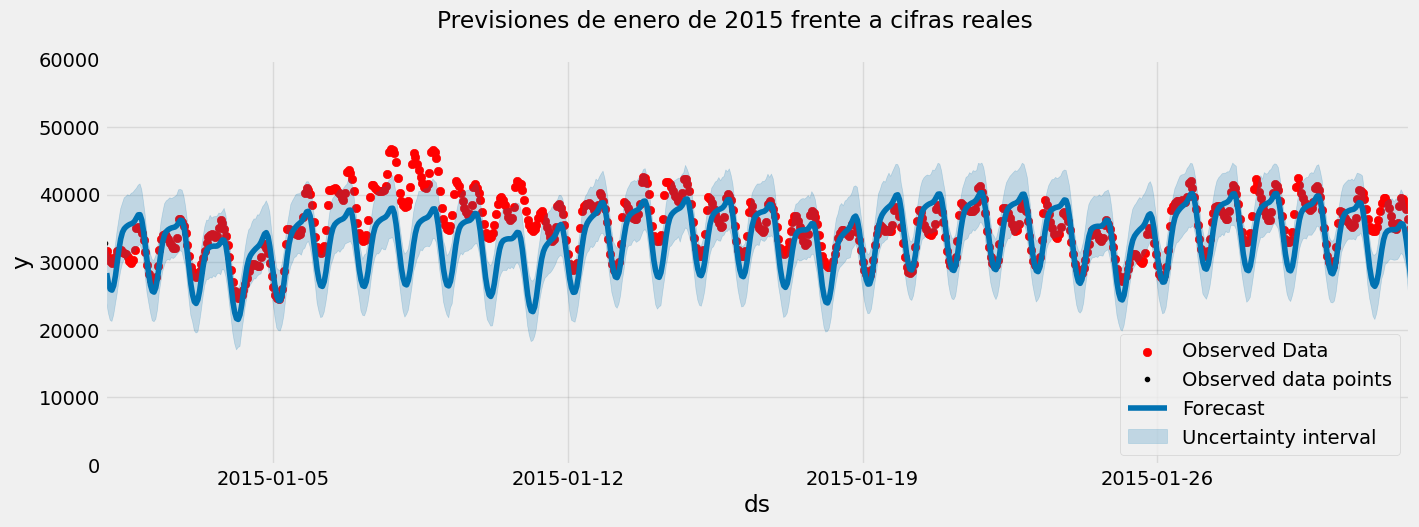

In [18]:
# Representar la previsión con los datos reales
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2015-02-01')

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Graficar los puntos observados
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r', label='Observed Data')
fig = model.plot(pjme_test_fcst, ax=ax)

ax.set_xbound(lower=start_date, upper=end_date)
ax.set_ylim(0, 60000)
ax.legend()
plot = plt.suptitle('Previsiones de enero de 2015 frente a cifras reales')

plt.show()

1. Observed Data (Datos Observados):
    - Qué es: Estos son los datos reales o históricos que tienes disponibles. Es lo que ha ocurrido en el pasado, lo que has medido u observado. En un gráfico, estos datos son usualmente representados como puntos.
    - Ejemplo: En el contexto de un modelo de consumo energético, los datos observados serían las mediciones diarias de consumo de electricidad que has recopilado en un período de tiempo.

2. Observed Data Points (Puntos de Datos Observados):
    - Qué es: Esencialmente, se refiere a los puntos individuales que componen los "datos observados". Cada punto es un par de valores (fecha y valor observado). No es un concepto diferente, sino una forma más detallada de referirse a los datos observados.
    - Ejemplo: En una serie temporal, cada punto de datos observado podría representar, por ejemplo, el consumo energético de un día específico.

3. Forecast (Pronóstico o Previsión):
    - Qué es: Es la predicción generada por el modelo. El modelo Prophet utiliza los datos históricos (observados) para generar un pronóstico de los valores futuros. El pronóstico se representa como una línea que sigue la tendencia estimada a futuro.
    - Ejemplo: En un modelo de consumo energético, el pronóstico sería la estimación del consumo de electricidad para los próximos días, semanas o meses, basado en los datos históricos.

4. Uncertainty (Incertidumbre):
    - Qué es: La incertidumbre representa la variabilidad o el rango en el que los valores predichos pueden estar, dado que el modelo nunca puede predecir con absoluta certeza. Prophet genera un intervalo de confianza que muestra el posible rango de los valores futuros. Generalmente, esto se visualiza como una sombra o área alrededor de la línea de pronóstico.
    - Ejemplo: En el pronóstico del consumo energético, la incertidumbre indicaría un rango dentro del cual se espera que los futuros valores de consumo se encuentren, por ejemplo, con un 95% de confianza.

# Semana única de predicciones

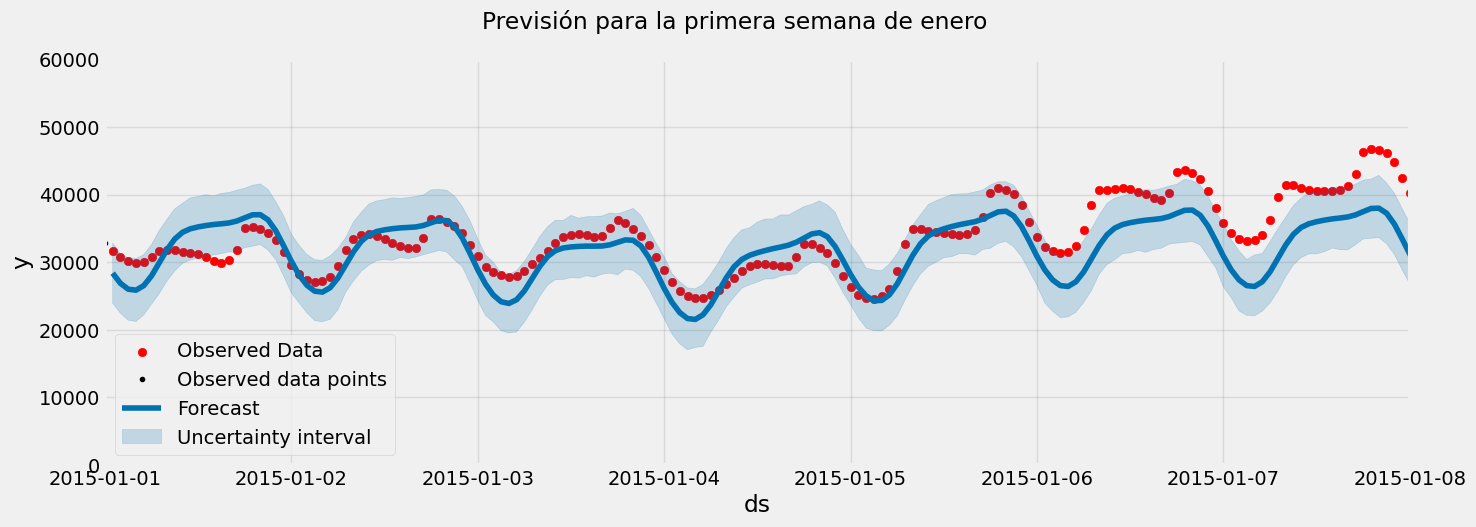

In [19]:
# Representar la previsión con los datos reales
start_date = pd.to_datetime('2015-01-01')
end_date = pd.to_datetime('2015-01-08')

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r', label='Observed Data')
fig = model.plot(pjme_test_fcst, ax=ax)

ax.set_xbound(lower=start_date, upper=end_date)
ax.set_ylim(0, 60000)
ax.legend()
plot = plt.suptitle('Previsión para la primera semana de enero')

plt.show()

# Métricas de error

Nuestra RMSE error es 43761675  
Nuestra MAE error es 5181.78  
Nuestra MAPE error es 16.5%


In [20]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

43811272.78007437

In [21]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5183.308123570645

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calcula el MAPE dados y_true y y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.505469633679194

# Añadir vacaciones
A continuación veremos si añadir indicadores de vacaciones ayuda a la precisión del modelo. Prophet incluye un parámetro *Efectos de las vacaciones* que puede proporcionarse al modelo antes del entrenamiento.

Utilizaremos el pandas `USFederalHolidayCalendar` para obtener la lista de días festivos.

In [23]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=pjme_train.index.min(),
                              end=pjme_train.index.max())
test_holidays = cal.holidays(start=pjme_test.index.min(),
                             end=pjme_test.index.max())

In [24]:
# Crear un marco de datos con las columnas holiday, ds
pjme['date'] = pjme.index.date
pjme['is_holiday'] = pjme.date.isin([d.date() for d in cal.holidays()])
holiday_df = pjme.loc[pjme['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2003-01-01 00:00:00,USFederalHoliday
1,2002-12-25 01:00:00,USFederalHoliday
2,2002-12-25 02:00:00,USFederalHoliday
3,2002-12-25 03:00:00,USFederalHoliday
4,2002-12-25 04:00:00,USFederalHoliday


In [25]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [26]:
# Configurar y entrenar el modelo con las vacaciones
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train.reset_index() \
                            .rename(columns={'Datetime':'ds',
                                             'PJME_MW':'y'}))

21:13:51 - cmdstanpy - INFO - Chain [1] start processing
21:15:12 - cmdstanpy - INFO - Chain [1] done processing


## Predecir con vacaciones

In [27]:
# Predecir sobre el conjunto de entrenamiento con el modelo
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test.reset_index() \
                                    .rename(columns={'Datetime':'ds'}))

## Trama Efecto Vacaciones

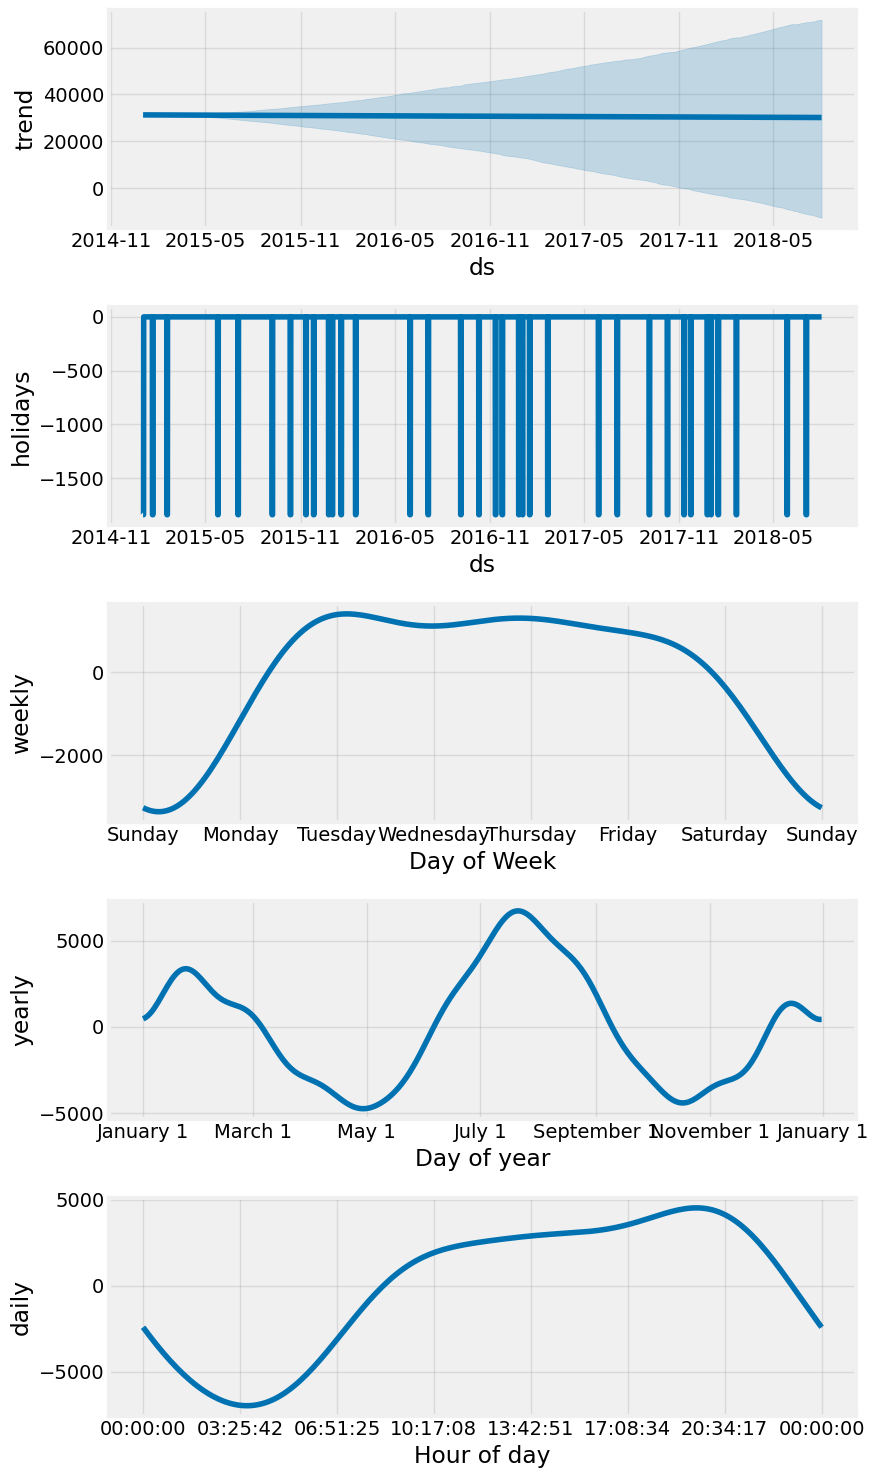

In [28]:
fig2 = model_with_holidays.plot_components(pjme_test_fcst_with_hols)

# Métricas de error con días festivos añadidos
Sorprendentemente, el error ha empeorado tras añadir los días festivos.

In [29]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

43858241.15027468

In [30]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5189.055267521968

In [31]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calcula el MAPE dados y_true y y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

16.546226516424806

# Comparar modelos sólo para fechas festivas
Vamos a trazar el modelo de previsión con y sin días festivos para el 4 de julio. Parece que el modelo con días festivos es más preciso para esta festividad.

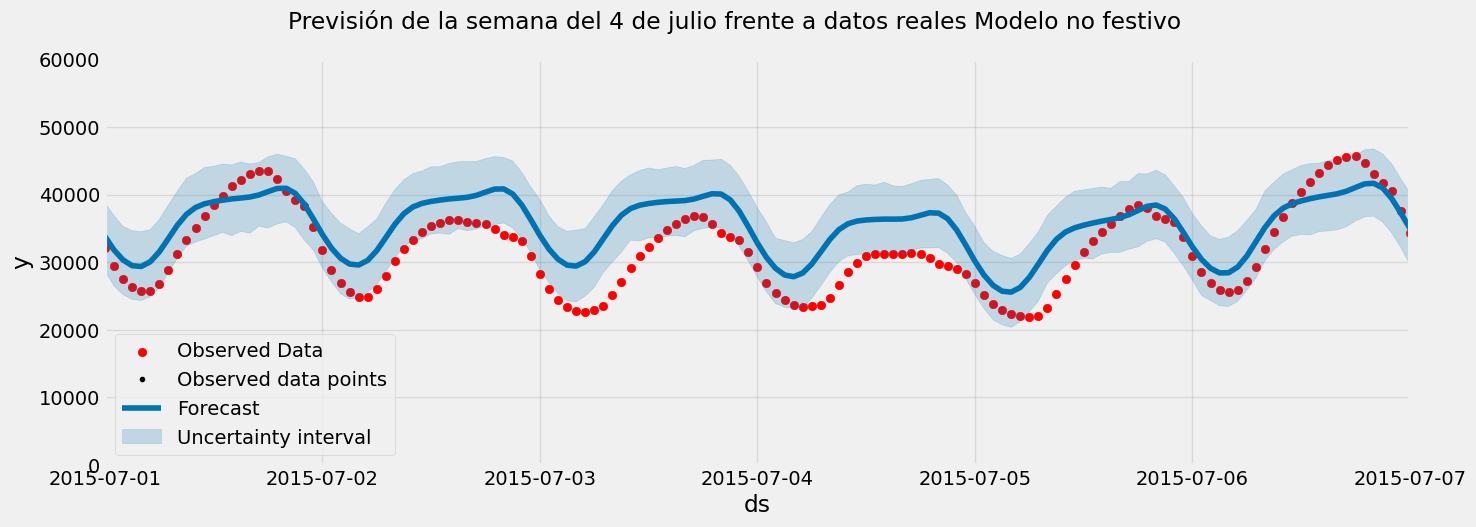

In [32]:
# Representar la previsión con los datos reales
start_date = pd.to_datetime('2015-07-01')
end_date = pd.to_datetime('2015-07-07')

# Graficar la previsión con los datos observados
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r', label='Observed Data')
fig = model.plot(pjme_test_fcst, ax=ax)

ax.set_xbound(lower=start_date, upper=end_date)
ax.set_ylim(0, 60000)
ax.legend()

plot = plt.suptitle('Previsión de la semana del 4 de julio frente a datos reales Modelo no festivo')
plt.show()

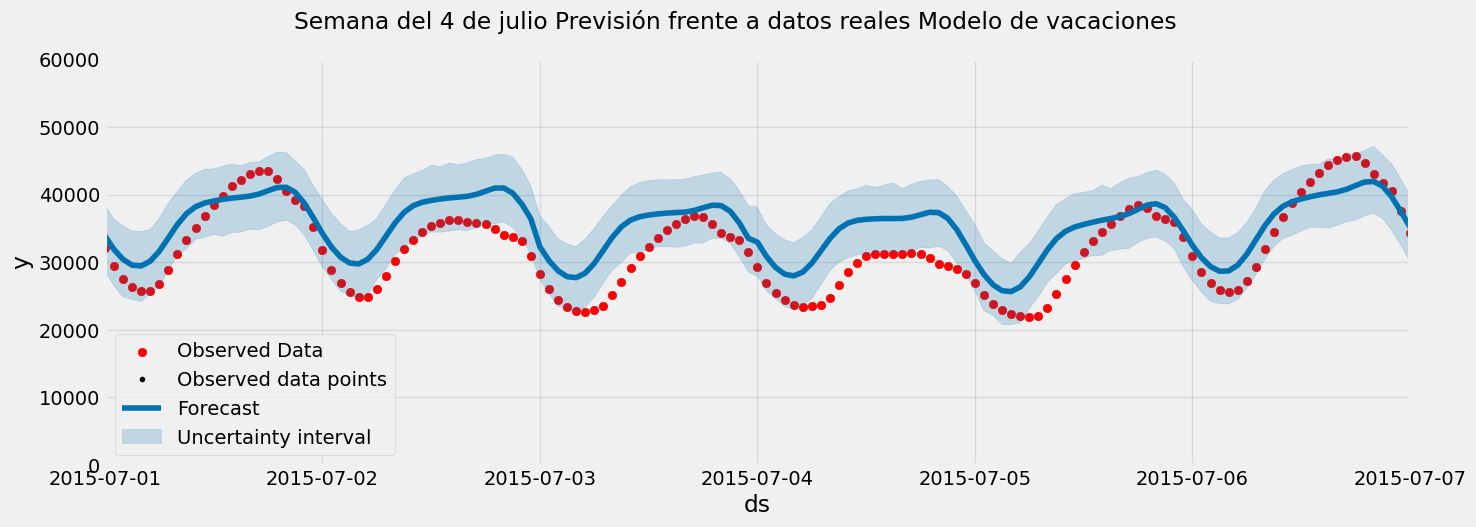

In [33]:
# Representar la previsión con los datos reales
start_date = pd.to_datetime('2015-07-01')
end_date = pd.to_datetime('2015-07-07')

# Graficar la previsión con los datos observados
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r', label='Observed Data')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)

ax.set_xbound(lower=start_date, upper=end_date)
ax.set_ylim(0, 60000)
ax.legend()

plot = plt.suptitle('Semana del 4 de julio Previsión frente a datos reales Modelo de vacaciones')
plt.show()

## Comparar error sólo para el 4 de julio
El error ha disminuido para esta fecha.

In [34]:
jul4_test = pjme_test.query('Datetime >= 20160407 and Datetime < 20160408')
jul4_pred = pjme_test_fcst.query('ds >= 20160407 and ds < 20160408')
jul4_pred_holiday_model = pjme_test_fcst_with_hols.query('ds >= 20160407 and ds < 20160408')

In [35]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred['yhat'])

2155.164621441292

In [36]:
mean_absolute_error(y_true=jul4_test['PJME_MW'],
                   y_pred=jul4_pred_holiday_model['yhat'])

2159.2370984773665

# Error de todos los días festivos
- ¡El error de las vacaciones ha subido! Esto es inesperado.

In [37]:
holiday_list = holiday_df['ds'].tolist()

In [38]:
hols_test = pjme_test.query('Datetime in @holiday_list')
hols_pred = pjme_test_fcst.query('ds in @holiday_list')
hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')

In [39]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])

5225.937456861032

In [40]:
mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred_holiday_model['yhat'])

5111.58111624033

# Identificar el error por festividad
- Podemos ver que los distintos días festivos responden de forma diferente en este modelo. El modelo funcionaría mejor si identificáramos específicamente los días festivos en lugar de agruparlos como "USFederalHolidays".

In [41]:
holiday_df['date'] = holiday_df['ds'].dt.date

for hol, d in holiday_df.groupby('date'):
    holiday_list = d['ds'].tolist()
    hols_test = pjme_test.query('Datetime in @holiday_list')
    if len(hols_test) == 0:
        continue
    hols_pred = pjme_test_fcst.query('ds in @holiday_list')
    hols_pred_holiday_model = pjme_test_fcst_with_hols.query('ds in @holiday_list')
    non_hol_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                   y_pred=hols_pred['yhat'])
    hol_model_error = mean_absolute_error(y_true=hols_test['PJME_MW'],
                       y_pred=hols_pred_holiday_model['yhat'])
    diff = non_hol_error - hol_model_error
    print(f'Holiday: {hol:%B %d, %Y}:    \n MAE (non-holiday model): {non_hol_error:0.1f} \n MAE (Holiday Model): {hol_model_error:0.1f} \n Diff {diff:0.1f}')

Holiday: January 01, 2015:    
 MAE (non-holiday model): 3094.0 
 MAE (Holiday Model): 2672.3 
 Diff 421.7
Holiday: January 19, 2015:    
 MAE (non-holiday model): 2416.3 
 MAE (Holiday Model): 2088.2 
 Diff 328.0
Holiday: February 16, 2015:    
 MAE (non-holiday model): 11106.7 
 MAE (Holiday Model): 12756.9 
 Diff -1650.2
Holiday: May 25, 2015:    
 MAE (non-holiday model): 1555.0 
 MAE (Holiday Model): 1616.7 
 Diff -61.7
Holiday: July 03, 2015:    
 MAE (non-holiday model): 6013.0 
 MAE (Holiday Model): 4305.9 
 Diff 1707.1
Holiday: September 07, 2015:    
 MAE (non-holiday model): 3851.6 
 MAE (Holiday Model): 4315.6 
 Diff -463.9
Holiday: October 12, 2015:    
 MAE (non-holiday model): 1578.1 
 MAE (Holiday Model): 1872.9 
 Diff -294.7
Holiday: November 11, 2015:    
 MAE (non-holiday model): 2038.5 
 MAE (Holiday Model): 1586.3 
 Diff 452.2
Holiday: November 26, 2015:    
 MAE (non-holiday model): 4659.3 
 MAE (Holiday Model): 3788.1 
 Diff 871.2
Holiday: December 25, 2015:    


# Error gráfico de cada previsión
- Podemos ver que ambos modelos generalizan bien, pero tienen problemas con los días de máxima demanda.
- Parece que no pronostican bien muchos días.

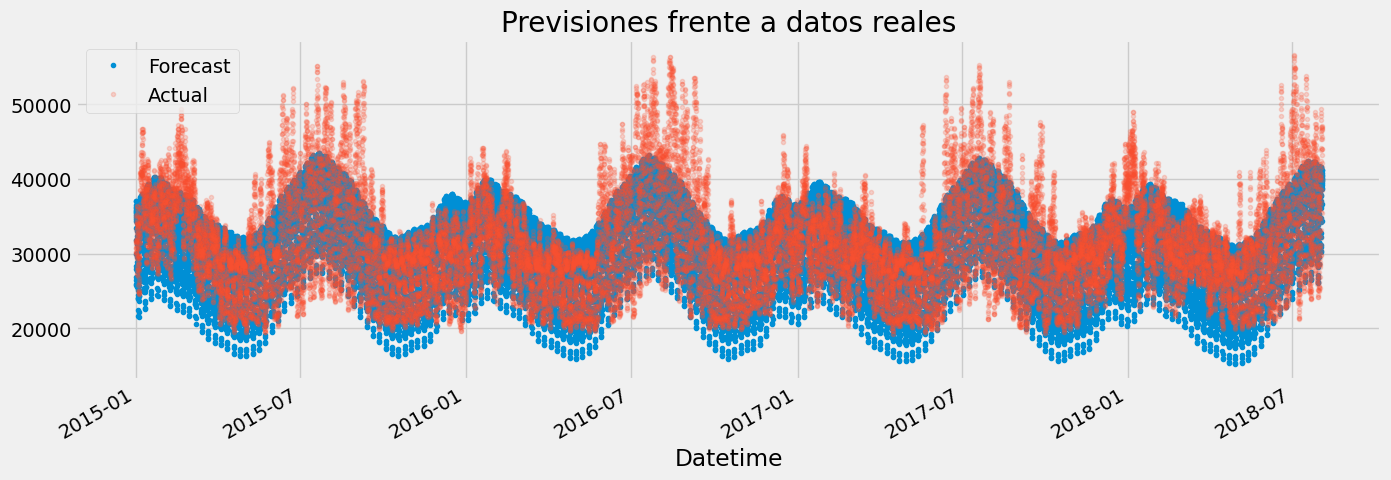

In [42]:
ax = pjme_test_fcst.set_index('ds')['yhat'].plot(figsize=(15, 5),
                                                 lw=0,
                                                 style='.')
pjme_test['PJME_MW'].plot(ax=ax,
                          style='.',
                          lw=0,
                          alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Previsiones frente a datos reales')
plt.show()

# Data Cleaning
- La limpieza de datos es una parte muy importante del proceso de previsión. Si los datos de entrada contienen valores basura, la previsión los utilizará al hacer predicciones y podría causar graves problemas.
- En los datos de entrenamiento tenemos algunas mediciones erróneas en las que los valores son muy inferiores. ¿Podrían ser la causa de la infraprevisión? Intentemos eliminar estos datos erróneos.

Este gráfico muestra los datos erróneos resaltados en rojo.

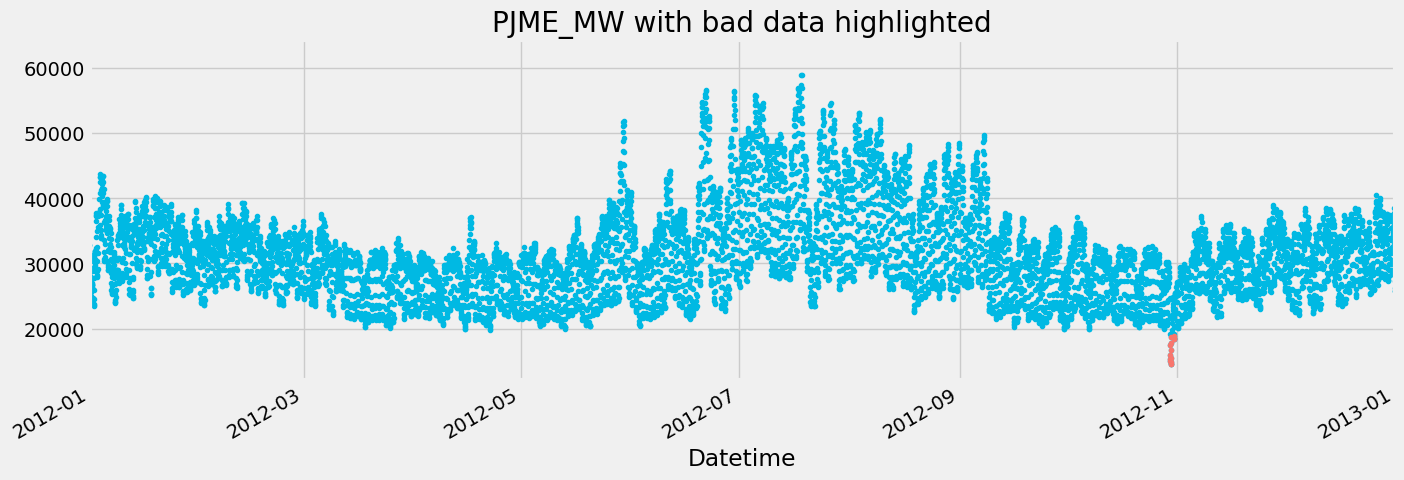

In [43]:
ax = pjme_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='PJME_MW with bad data highlighted',
                     xlim=('01-01-2012','01-01-2013')
                    )
pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

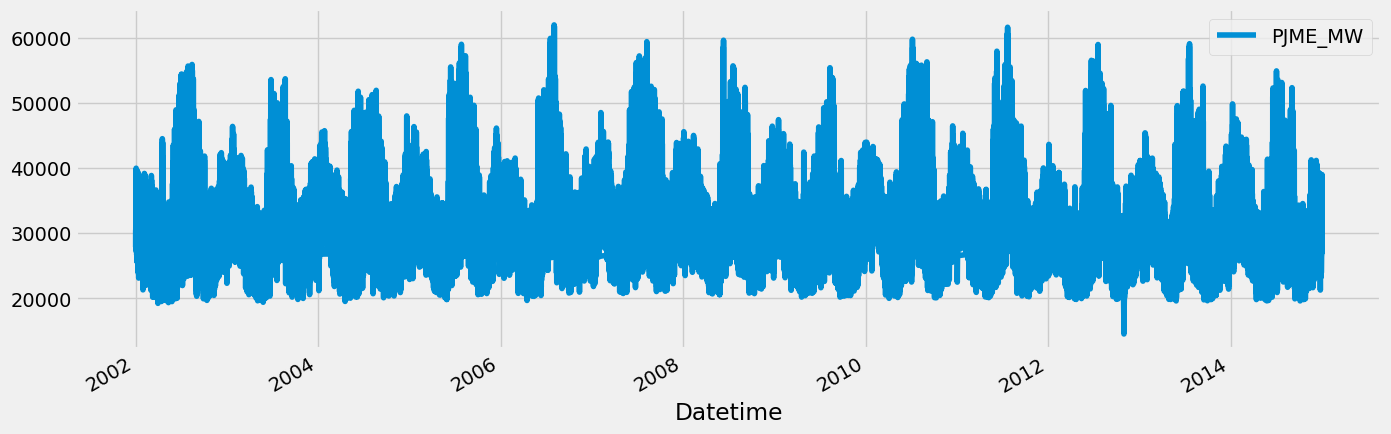

In [44]:
pjme_train.plot(figsize=(15, 5))
plt.show()

¿Qué ha provocado este descenso de la demanda energética? El huracán Sandy.


**Los días 29 y 30 de octubre, el huracán Sandy trajo fuertes vientos e inundaciones costeras a gran parte del este de Estados Unidos, dejando sin electricidad a unos 8 millones de clientes. La tormenta, que tocó tierra cerca de Atlantic City (Nueva Jersey) como huracán de categoría 1, dejó sin electricidad a decenas de hogares y empresas de Nueva Jersey (2,7 millones), Nueva York (2,2 millones), Pensilvania (1,2 millones), Connecticut (620.000), Massachusetts (400.000), Maryland (290.000), Virginia Occidental (268.000), Ohio (250.000) y Nuevo Hampshire (210.000). También se registraron cortes de electricidad en otros estados, como Virginia, Maine, Rhode Island, Vermont y el Distrito de Columbia**.


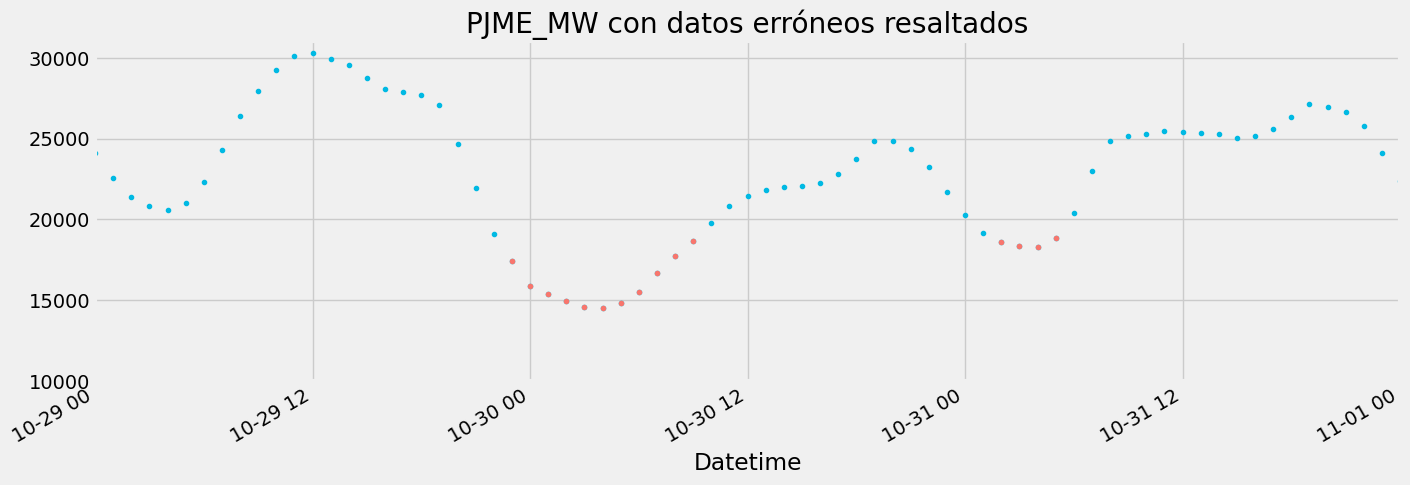

In [45]:
ax = pjme_train.plot(style='.',
                     figsize=(15,5),
                     color=color_pal[5],
                     title='PJME_MW con datos erróneos resaltados',
                     xlim=('10-29-2012','11-01-2012'),
                     ylim=(10000, 31000)
                    )
pjme_train.query('PJME_MW < 19000').plot(style='.',
                                             figsize=(15,5),
                                             color=color_pal[0],
                                             ax=ax)
ax.legend().set_visible(False)
plt.show()

In [46]:
# Clean Data
pjme_train['PJME_MW_clean'] = pjme_train['PJME_MW']
pjme_train.loc[pjme_train['PJME_MW'] < 19000, 'PJME_MW_clean'] = np.nan

# Entrenar el modelo con datos limpios
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Datetime':'ds',
                               'PJME_MW_clean':'y'})
         )

# Predecir en el conjunto de entrenamiento con un modelo limpio
pjme_test_fcst_clean = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

21:15:32 - cmdstanpy - INFO - Chain [1] start processing
21:16:44 - cmdstanpy - INFO - Chain [1] done processing


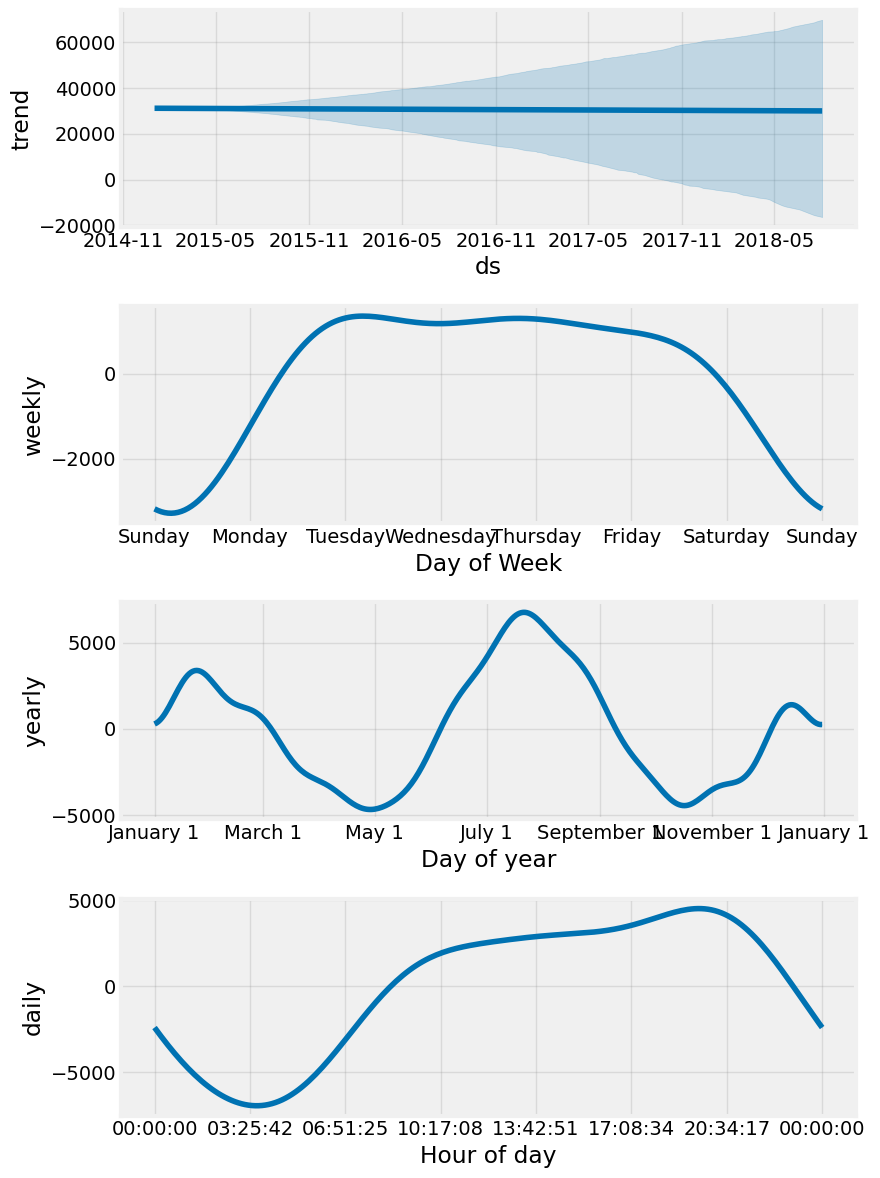

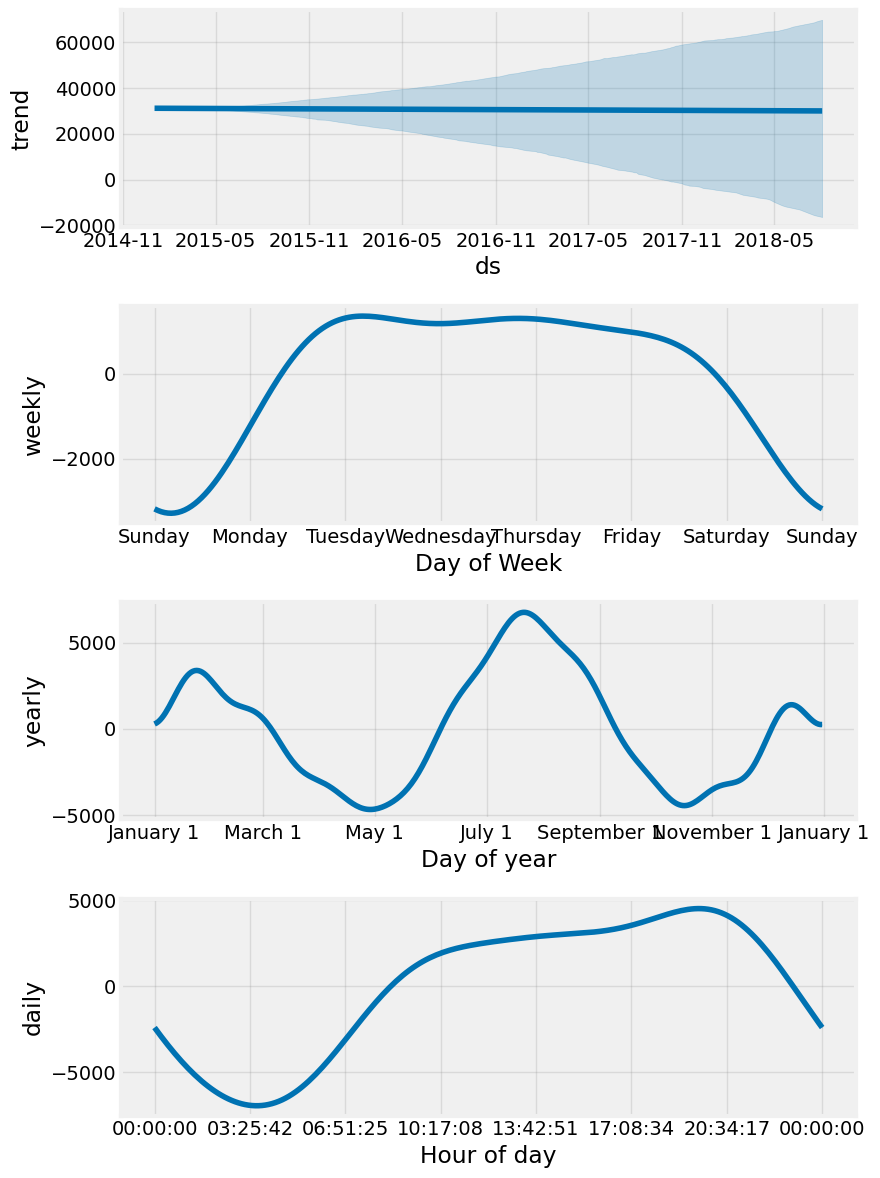

In [49]:
model.plot_components(pjme_test_fcst_clean)

Tras la limpieza, observamos una ligera mejora de la puntuación en comparación con el primer modelo. Una mayor limpieza de los datos, junto con las vacaciones, podría dar resultados aún mejores.

In [47]:
mse_clean = mean_squared_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst_clean['yhat']
                              )
mae_clean = mean_absolute_error(y_true=pjme_test['PJME_MW'],
                                y_pred=pjme_test_fcst_clean['yhat']
                               )
mape_clean = mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                                            y_pred=pjme_test_fcst_clean['yhat'])
print(f'El modelo de datos limpios tiene MSE {mse_clean:0.4f} - MAE {mae_clean:0.4f} - MAPE {mape_clean:0.4f}')

El modelo de datos limpios tiene MSE 43790436.5402 - MAE 5181.8664 - MAPE 16.5090


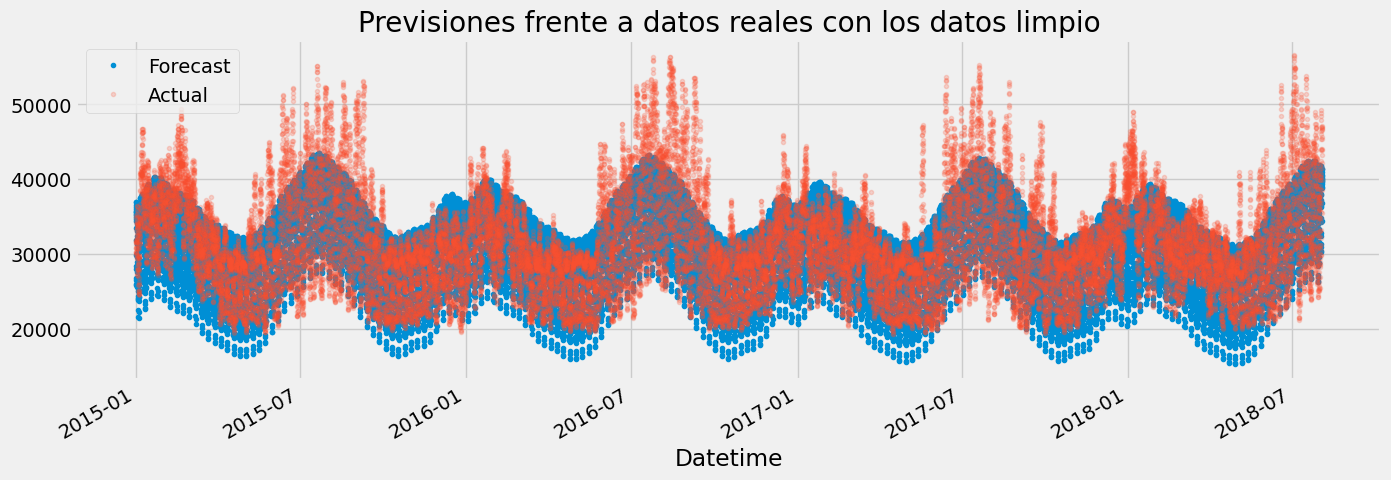

In [48]:
ax = pjme_test_fcst_clean.set_index('ds')['yhat'] \
    .plot(figsize=(15, 5), lw=0, style='.')
pjme_test['PJME_MW'].plot(ax=ax, style='.', lw=0, alpha=0.2)
plt.legend(['Forecast','Actual'])
plt.title('Previsiones frente a datos reales con los datos limpio')
plt.show()